## Import libraries

In [11]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Embedding, Bidirectional, LSTM, 
    Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, 
    Attention, MultiHeadAttention, Input, GRU)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from nltk import FreqDist
import pickle

In [2]:
df = pd.read_csv("./Data/IMDB Dataset.csv")
df.head()

,review_es,review_en,review_fr,sentiment
0,Uno de los otros críticos ha mencionado que de...,One of the other reviewers has mentioned that ...,L'un des autres critiques a mentionné qu'après...,positive
1,Una pequeña pequeña producción.La técnica de f...,A wonderful little production. The filming tec...,Une merveilleuse petite production. La techniq...,positive
2,Pensé que esta era una manera maravillosa de p...,I thought this was a wonderful way to spend ti...,J'ai pensé que c'était une merveilleuse façon ...,positive
3,"Básicamente, hay una familia donde un niño peq...",Basically there's a family where a little boy ...,"En gros, il y a une famille où un petit garçon...",negative
4,"El ""amor en el tiempo"" de Petter Mattei es una...","Petter Mattei's ""Love in the Time of Money"" is...","""L'amour au temps de l'argent"" de Petter Matte...",positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_es  50000 non-null  object
 1   review_en  50000 non-null  object
 2   review_fr  50000 non-null  object
 3   sentiment  50000 non-null  object
dtypes: object(4)
memory usage: 1.5+ MB


In [4]:
df = df[['review_fr', 'sentiment']]
df.head()

,review_fr,sentiment
0,L'un des autres critiques a mentionné qu'après...,positive
1,Une merveilleuse petite production. La techniq...,positive
2,J'ai pensé que c'était une merveilleuse façon ...,positive
3,"En gros, il y a une famille où un petit garçon...",negative
4,"""L'amour au temps de l'argent"" de Petter Matte...",positive


## Process data

In [6]:
def cleaning_texts(texts):
    clean_texts = []
    for text in texts:
        text = re.sub(r'[^a-zA-Záéíóúüñàâäéèêëîïôœùûç\']', ' ', text)
        text = text.lower().strip()
        text = re.sub(r'\s+', ' ', text)
        clean_texts.append(text)
    return clean_texts

In [7]:
def tokenize_texts(texts):
    tokenized_texts = []
    for text in texts:
        tokenized_texts.append(text.split())
    return tokenized_texts

In [8]:
def remove_stopwords(texts):
    texts_without_stopwords = []
    nltk.download("stopwords")
    stop_words = set(stopwords.words("spanish")) | set(stopwords.words("english")) | set(stopwords.words("french"))
    for text in texts:
        texts_without_stopwords.append([word for word in text if word not in stop_words])
    return texts_without_stopwords

In [9]:
def vectorize_texts(texts, vocabulary):
    vectoriced_texts = []
    for i, text in enumerate(texts):
        vectoriced_text = []
        for j, word in enumerate(text):
            if word in vocabulary:
                vectoriced_text.append(vocabulary[word]) 
            else:
                vectoriced_text.append(0) 
        vectoriced_texts.append(vectoriced_text)
    return vectoriced_texts

In [12]:
texts = df['review_fr'].to_list()
clean_texts = cleaning_texts(texts)
tokenized_texts = tokenize_texts(clean_texts)
tokenized_texts = remove_stopwords(tokenized_texts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hermann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Word Cloud

In [13]:
corpus = ' '.join(' '.join(text) for text in tokenized_texts)
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(corpus)

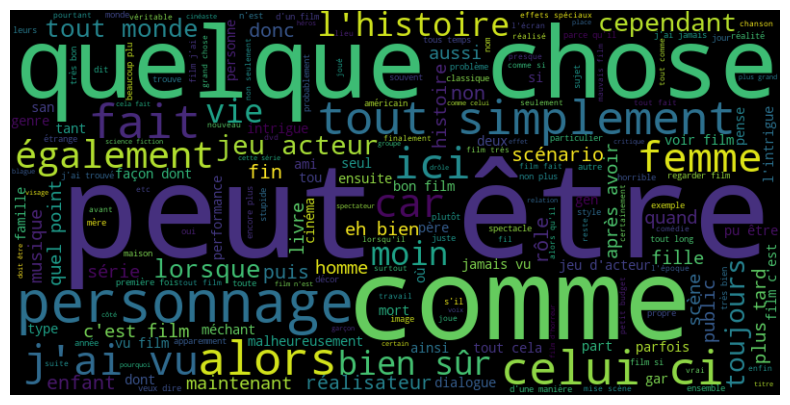

In [14]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Top words

In [15]:
words = []
for text in tokenized_texts:
    words.extend(text)
frequency = FreqDist(words)
top_20 = frequency.most_common(20)
words, freq = zip(*top_20)

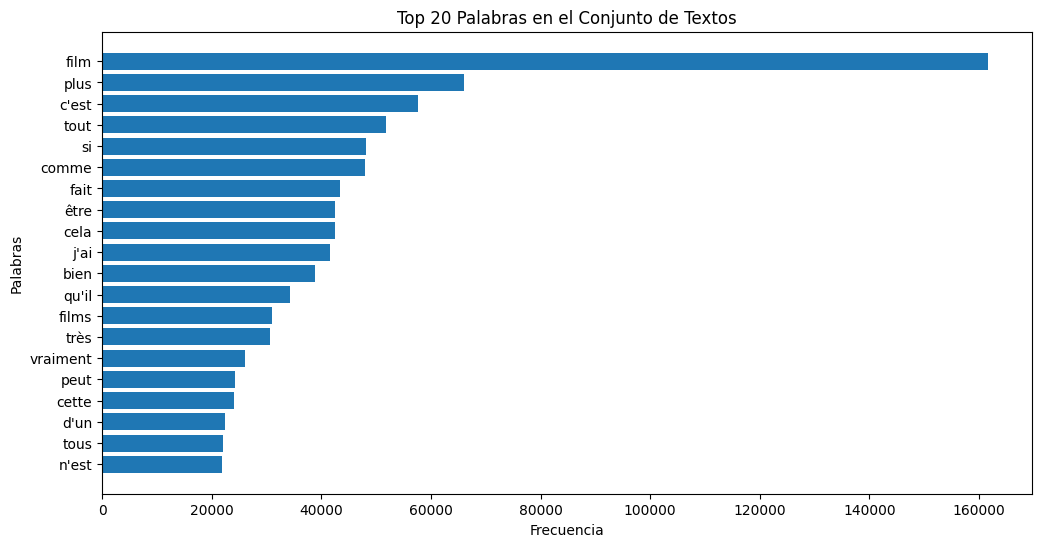

In [16]:
plt.figure(figsize=(12, 6))
plt.barh(words, freq)
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('Top 20 Palabras en el Conjunto de Textos')
plt.gca().invert_yaxis() 
plt.show()

## Word2Vec Model

In [17]:
model_word2vec = Word2Vec(tokenized_texts, vector_size=50, window=10, min_count=10, workers=4)
model_word2vec.train(tokenized_texts,total_examples=model_word2vec.corpus_count, epochs=20)
model_word2vec.save("./API/Models/Word2Vec_fr")

#### Semantically close words

In [19]:
model_word2vec.wv.most_similar('homme')

[('adage', 0.7775959372520447),
 ('garçon', 0.7402852773666382),
 ('imposteur', 0.7171878218650818),
 ("l'homme", 0.703575074672699),
 ('étalon', 0.6775297522544861),
 ('escroc', 0.6586135625839233),
 ('enfant', 0.656497597694397),
 ('arnaqueur', 0.6518439054489136),
 ('archétype', 0.6275883316993713),
 ('imbécile', 0.62298184633255)]

In [20]:
model_word2vec.wv.most_similar('film')

[('cela', 0.7642235159873962),
 ('vraiment', 0.7163482308387756),
 ("c'est", 0.7034652829170227),
 ('car', 0.6732190251350403),
 ('ça', 0.6397241353988647),
 ('donc', 0.6297046542167664),
 ('certainement', 0.6293404698371887),
 ("l'ensemble", 0.627954363822937),
 ('visionnage', 0.6058399677276611),
 ('honnêtement', 0.6041226387023926)]

In [21]:
model_word2vec.wv.most_similar('réalisateur')

[('scénariste', 0.8401922583580017),
 ('cinéaste', 0.8148030042648315),
 ('producteur', 0.7326705455780029),
 ('monteur', 0.7034500241279602),
 ('débutant', 0.6819268465042114),
 ('amenabar', 0.6812214851379395),
 ('verhoeven', 0.6422503590583801),
 ('palma', 0.6384413242340088),
 ('ram', 0.6336460709571838),
 ('gopal', 0.6291388273239136)]

## Vectorize texts

In [23]:
model_word2vec = Word2Vec.load("./API/Models/Word2Vec_fr")
vocabulary = model_word2vec.wv.key_to_index
with open("./API/vocabulary/vocabulary_fr", "wb") as file:
    pickle.dump(vocabulary, file)

In [24]:
maxlen = 150
max_words = len(vocabulary)

vectorized_texts = vectorize_texts(tokenized_texts, vocabulary)
X = pad_sequences(vectorized_texts, maxlen=maxlen)
y = df['sentiment'].apply(lambda x : 1 if x == 'positive' else 0).to_numpy()

## Split dataset into training and test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build embedding matrix

In [27]:
embedding_matrix = np.zeros((max_words, 50))
for word, i in vocabulary.items():
    if i < max_words:
        if word in vocabulary:
            embedding_matrix[i] = model_word2vec.wv[word]

## Plot confusion matrix

In [28]:
def plot_confusion_matrix(y_true, y_pred):
    
    conf_matrix = confusion_matrix(y_true, y_pred) 
    
    fig, ax = plt.subplots(figsize=(3, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.8)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large')
 
    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()

## Bidirectional LSTM Model

In [35]:
model_lstm = Sequential()
model_lstm.add(Input(shape=(maxlen,)))
model_lstm.add(Embedding(input_dim=max_words, output_dim=50, weights=[embedding_matrix], trainable=False))
model_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))  
model_lstm.add(Bidirectional(LSTM(64, return_sequences=True))) 
model_lstm.add(Flatten())
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid')) 

In [36]:
model_lstm.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', Recall(), Precision()]
)

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 50)           1686000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 150, 128)         58880     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 150, 128)         98816     
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 19200)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1228864   
                                                                 
 dense_3 (Dense)             (None, 1)                

In [37]:
checkpoint = ModelCheckpoint(
    './API/Models/model_lstm_fr.h5', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', 
    verbose=0
)  

model_lstm_history = model_lstm.fit(
    X_train, y_train, validation_split=0.2, 
    epochs=10, batch_size=128, callbacks=[checkpoint]
)

Epoch 1/10
250/250 [==============================] - 358s 1s/step - loss: 0.3466 - accuracy: 0.8497 - recall_1: 0.8499 - precision_1: 0.8490 - val_loss: 0.2975 - val_accuracy: 0.8750 - val_recall_1: 0.8257 - val_precision_1: 0.9160
Epoch 2/10
250/250 [==============================] - 325s 1s/step - loss: 0.2560 - accuracy: 0.8950 - recall_1: 0.8960 - precision_1: 0.8937 - val_loss: 0.2702 - val_accuracy: 0.8884 - val_recall_1: 0.8895 - val_precision_1: 0.8875
Epoch 3/10
250/250 [==============================] - 327s 1s/step - loss: 0.2065 - accuracy: 0.9161 - recall_1: 0.9170 - precision_1: 0.9149 - val_loss: 0.2914 - val_accuracy: 0.8802 - val_recall_1: 0.9122 - val_precision_1: 0.8574
Epoch 4/10
250/250 [==============================] - 328s 1s/step - loss: 0.1467 - accuracy: 0.9424 - recall_1: 0.9435 - precision_1: 0.9411 - val_loss: 0.3516 - val_accuracy: 0.8854 - val_recall_1: 0.8785 - val_precision_1: 0.8907
Epoch 5/10
250/250 [==============================] - 328s 1s/step -

In [38]:
model_lstm = load_model("./API/Models/model_lstm_fr.h5")
y_pred_lstm = np.round(model_lstm.predict(X_test).T).astype(int)[0]

313/313 [==============================] - 23s 68ms/step


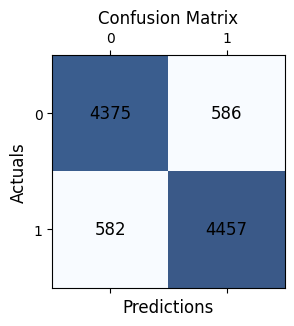

In [39]:
plot_confusion_matrix(y_test, y_pred_lstm)

In [40]:
print(classification_report(y_test,y_pred_lstm))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4961
           1       0.88      0.88      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Bidirectional GRU Model

In [41]:
model_gru = Sequential()
model_gru.add(Input(shape=(maxlen,)))
model_gru.add(Embedding(input_dim=max_words, output_dim=50, weights=[embedding_matrix], trainable=False))
model_gru.add(GRU(64, return_sequences=True))  
model_gru.add(GRU(64, return_sequences=True)) 
model_gru.add(Flatten())
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dense(1, activation='sigmoid')) 

In [42]:
model_gru.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', Recall(), Precision()]
)

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 50)           1686000   
                                                                 
 gru (GRU)                   (None, 150, 64)           22272     
                                                                 
 gru_1 (GRU)                 (None, 150, 64)           24960     
                                                                 
 flatten_2 (Flatten)         (None, 9600)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                614464    
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,347,761
Trainable params: 661,761
Non-

In [43]:
checkpoint = ModelCheckpoint(
    './API/Models/model_gru_fr.h5', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', 
    verbose=0
)  

model_gru_history = model_gru.fit(
    X_train, y_train, validation_split=0.2, 
    epochs=10, batch_size=128, callbacks=[checkpoint]
)

Epoch 1/10
250/250 [==============================] - 157s 609ms/step - loss: 0.3739 - accuracy: 0.8322 - recall_2: 0.8317 - precision_2: 0.8320 - val_loss: 0.3194 - val_accuracy: 0.8646 - val_recall_2: 0.8177 - val_precision_2: 0.9023
Epoch 2/10
250/250 [==============================] - 181s 726ms/step - loss: 0.2668 - accuracy: 0.8890 - recall_2: 0.8928 - precision_2: 0.8856 - val_loss: 0.2991 - val_accuracy: 0.8767 - val_recall_2: 0.8692 - val_precision_2: 0.8825
Epoch 3/10
250/250 [==============================] - 187s 749ms/step - loss: 0.2024 - accuracy: 0.9187 - recall_2: 0.9209 - precision_2: 0.9165 - val_loss: 0.3336 - val_accuracy: 0.8640 - val_recall_2: 0.8865 - val_precision_2: 0.8483
Epoch 4/10
250/250 [==============================] - 193s 771ms/step - loss: 0.1416 - accuracy: 0.9467 - recall_2: 0.9471 - precision_2: 0.9460 - val_loss: 0.3699 - val_accuracy: 0.8683 - val_recall_2: 0.8802 - val_precision_2: 0.8596
Epoch 5/10
250/250 [==============================] - 18

In [44]:
model_gru = load_model("./API/Models/model_gru_fr.h5")
y_pred_gru = np.round(model_gru.predict(X_test).T).astype(int)[0]

313/313 [==============================] - 19s 55ms/step


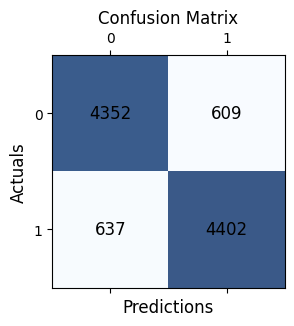

In [45]:
plot_confusion_matrix(y_test, y_pred_gru)

In [46]:
print(classification_report(y_test,y_pred_gru))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      4961
           1       0.88      0.87      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## CNN Model

In [47]:
model_cnn = Sequential()
model_cnn.add(Input(shape=(maxlen,)))
model_cnn.add(Embedding(input_dim=max_words, output_dim=50, weights=[embedding_matrix], trainable=False))
model_cnn.add(Conv1D(256, kernel_size=8, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(64, kernel_size=4, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

In [48]:
model_cnn.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', Recall(), Precision()]
)

model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 50)           1686000   
                                                                 
 conv1d (Conv1D)             (None, 143, 256)          102656    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 71, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 68, 64)            65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 34, 64)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 2176)             

In [49]:
checkpoint = ModelCheckpoint(
    './API/Models/model_cnn_fr.h5', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', 
    verbose=0
)  

model_cnn_history = model_cnn.fit(
    X_train, y_train, validation_split=0.2, 
    epochs=10, batch_size=128, callbacks=[checkpoint]
)

Epoch 1/10
250/250 [==============================] - 83s 320ms/step - loss: 0.4611 - accuracy: 0.7806 - recall_3: 0.7832 - precision_3: 0.7783 - val_loss: 0.3378 - val_accuracy: 0.8561 - val_recall_3: 0.8972 - val_precision_3: 0.8291
Epoch 2/10
250/250 [==============================] - 87s 350ms/step - loss: 0.3196 - accuracy: 0.8652 - recall_3: 0.8691 - precision_3: 0.8618 - val_loss: 0.3092 - val_accuracy: 0.8641 - val_recall_3: 0.8625 - val_precision_3: 0.8653
Epoch 3/10
250/250 [==============================] - 89s 356ms/step - loss: 0.2876 - accuracy: 0.8795 - recall_3: 0.8835 - precision_3: 0.8760 - val_loss: 0.3177 - val_accuracy: 0.8633 - val_recall_3: 0.8220 - val_precision_3: 0.8959
Epoch 4/10
250/250 [==============================] - 83s 332ms/step - loss: 0.2466 - accuracy: 0.8996 - recall_3: 0.9019 - precision_3: 0.8973 - val_loss: 0.3562 - val_accuracy: 0.8460 - val_recall_3: 0.9342 - val_precision_3: 0.7941
Epoch 5/10
250/250 [==============================] - 86s 34

In [50]:
model_cnn = load_model("./API/Models/model_cnn_fr.h5")
y_pred_cnn = np.round(model_cnn.predict(X_test).T).astype(int)[0]

313/313 [==============================] - 9s 27ms/step


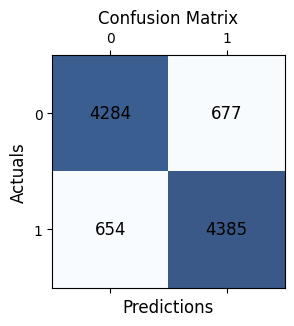

In [51]:
plot_confusion_matrix(y_test, y_pred_cnn)

In [52]:
print(classification_report(y_test,y_pred_cnn))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      4961
           1       0.87      0.87      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



## Attention Model

In [53]:
inputs = Input(shape=(maxlen,))
x = Embedding(input_dim=max_words, output_dim=50, weights=[embedding_matrix], trainable=False)(inputs)
x = MultiHeadAttention(num_heads=16, key_dim=16, value_dim=16)(x, x)
x = MaxPooling1D(pool_size=2)(x)
x = MultiHeadAttention(num_heads=8, key_dim=16, value_dim=16)(x, x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dense(units=1, activation='sigmoid')(x)
model_attention = Model(inputs, x)

In [54]:
model_attention.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', Recall(), Precision()]
)
model_attention.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 150, 50)      1686000     ['input_5[0][0]']                
                                                                                                  
 multi_head_attention (MultiHea  (None, 150, 50)     52018       ['embedding_4[0][0]',            
 dAttention)                                                      'embedding_4[0][0]']            
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 75, 50)      0           ['multi_head_attention[0][0]'

In [55]:
checkpoint = ModelCheckpoint(
    './API/Models/model_attention_fr.h5', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', 
    verbose=0
)  

model_attention_history = model_attention.fit(
    X_train, y_train, validation_split=0.2, 
    epochs=10, batch_size=128, callbacks=[checkpoint]
)

Epoch 1/10
250/250 [==============================] - 516s 2s/step - loss: 0.3519 - accuracy: 0.8446 - recall_4: 0.8465 - precision_4: 0.8426 - val_loss: 0.3117 - val_accuracy: 0.8640 - val_recall_4: 0.9075 - val_precision_4: 0.8349
Epoch 2/10
250/250 [==============================] - 481s 2s/step - loss: 0.3100 - accuracy: 0.8689 - recall_4: 0.8725 - precision_4: 0.8658 - val_loss: 0.3055 - val_accuracy: 0.8721 - val_recall_4: 0.8995 - val_precision_4: 0.8528
Epoch 3/10
250/250 [==============================] - 491s 2s/step - loss: 0.3023 - accuracy: 0.8727 - recall_4: 0.8753 - precision_4: 0.8703 - val_loss: 0.3083 - val_accuracy: 0.8651 - val_recall_4: 0.9093 - val_precision_4: 0.8355
Epoch 4/10
250/250 [==============================] - 290s 1s/step - loss: 0.2944 - accuracy: 0.8771 - recall_4: 0.8818 - precision_4: 0.8730 - val_loss: 0.2906 - val_accuracy: 0.8735 - val_recall_4: 0.8655 - val_precision_4: 0.8796
Epoch 5/10
250/250 [==============================] - 285s 1s/step -

In [56]:
model_attention = load_model("./API/Models/model_attention_fr.h5")
y_pred_attention = np.round(model_attention.predict(X_test).T).astype(int)[0]

313/313 [==============================] - 42s 133ms/step


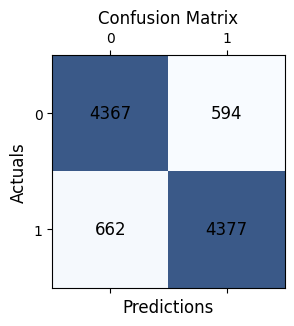

In [57]:
plot_confusion_matrix(y_test, y_pred_attention)

In [58]:
print(classification_report(y_test,y_pred_attention))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      4961
           1       0.88      0.87      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



## LSTM+Attention Model

In [59]:
inputs = Input(shape=(maxlen,))
x = Embedding(input_dim=max_words, output_dim=50, weights=[embedding_matrix], trainable=False)(inputs)
lstm_1 = Bidirectional(LSTM(units=64, return_sequences=True))(x)
lstm_2 = Bidirectional(LSTM(units=64, return_sequences=True))(x)
x = MultiHeadAttention(num_heads=8, key_dim=16, value_dim=16)(lstm_1, lstm_2)
x = MultiHeadAttention(num_heads=4, key_dim=16, value_dim=16)(x, x)
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dense(units=1, activation='sigmoid')(x)
model_lstm_attention = Model(inputs, x)

In [60]:
model_lstm_attention.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', Recall(), Precision()]
)
model_lstm_attention.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 150, 50)      1686000     ['input_6[0][0]']                
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 150, 128)    58880       ['embedding_5[0][0]']            
 )                                                                                                
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 150, 128)    58880       ['embedding_5[0][0]']      

In [61]:
checkpoint = ModelCheckpoint(
    './API/Models/model_lstm_attention_fr.h5', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', 
    verbose=0
)  

model_lstm_attention_history = model_lstm_attention.fit(
    X_train, y_train, validation_split=0.2, 
    epochs=10, batch_size=128, callbacks=[checkpoint]
)

Epoch 1/10
250/250 [==============================] - 590s 2s/step - loss: 0.3352 - accuracy: 0.8529 - recall_5: 0.8548 - precision_5: 0.8510 - val_loss: 0.2761 - val_accuracy: 0.8870 - val_recall_5: 0.9118 - val_precision_5: 0.8687
Epoch 2/10
250/250 [==============================] - 606s 2s/step - loss: 0.2669 - accuracy: 0.8918 - recall_5: 0.8947 - precision_5: 0.8892 - val_loss: 0.2606 - val_accuracy: 0.8932 - val_recall_5: 0.9247 - val_precision_5: 0.8699
Epoch 3/10
250/250 [==============================] - 893s 4s/step - loss: 0.2382 - accuracy: 0.9053 - recall_5: 0.9081 - precision_5: 0.9025 - val_loss: 0.2767 - val_accuracy: 0.8955 - val_recall_5: 0.9277 - val_precision_5: 0.8715
Epoch 4/10
250/250 [==============================] - 1007s 4s/step - loss: 0.2091 - accuracy: 0.9169 - recall_5: 0.9199 - precision_5: 0.9140 - val_loss: 0.2623 - val_accuracy: 0.8924 - val_recall_5: 0.9093 - val_precision_5: 0.8796
Epoch 5/10
250/250 [==============================] - 976s 4s/step 

In [62]:
model_lstm_attention = load_model("./API/Models/model_lstm_attention_fr.h5")
y_pred_lstm_attention = np.round(model_lstm_attention.predict(X_test).T).astype(int)[0]

313/313 [==============================] - 94s 291ms/step


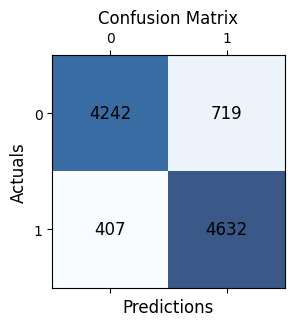

In [63]:
plot_confusion_matrix(y_test, y_pred_lstm_attention)

In [64]:
print(classification_report(y_test,y_pred_lstm_attention))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      4961
           1       0.87      0.92      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

